In [1]:
from imposm.parser import OSMParser
import numpy as np
#import geopandas as gpd
import pandas as pd

In [2]:
osmfile='/media/tobiasseidel/OSM/power_plant.osm'
# simple class that handles the parsed OSM data.
#Europes borders:-26,28,50,75
class Counter(object):
    CollectNodes=pd.DataFrame()
    CollectWays=pd.DataFrame()
    CollectCoords=pd.DataFrame()
    CollectRelations=pd.DataFrame()
    
    def ways(self, ways):
        for way in ways:
            C=pd.DataFrame([way[0],way[1],way[2:]]).transpose()
            C.columns=["id","tags","refs"]
            self.CollectWays=self.CollectWays.append(C)
    def coords(self,coordinates):
        for nid,coord0,coord1 in coordinates:
            C=pd.DataFrame([nid,coord0,coord1]).transpose()
            C.columns=["id","x","y"]
            self.CollectCoords=self.CollectCoords.append(C)
    def nodes(self,nodes):
        for nid,tags,coords in nodes:
            C=pd.DataFrame([nid,tags,coords[0],coords[1]]).transpose()
            C.columns=["id","tags","x","y"]
            self.CollectNodes=self.CollectNodes.append(C)
            #break #only take the first
        
    def relations(self,relations):
        for nid,tags,rels in relations:
            C=pd.DataFrame([nid,tags,rels]).transpose()
            C.columns=["id","tags","rels"]
            self.CollectRelations=self.CollectRelations.append(C)

    def findTag(self,key,value):
        withkey=self.CollectWays[self.CollectWays.tags.map(lambda x: key in x.keys())]
        ways=withkey[withkey.tags.map(lambda x: x[key].startswith(value))]
        withkey=self.CollectNodes[self.CollectNodes.tags.map(lambda x: key in x.keys())]
        rel0=ways.refs.map(lambda x: x[0][0])
        relCoords=counter.CollectCoords.set_index("id").loc[rel0]
        ways["x"]=relCoords.x.values
        ways["y"]=relCoords.y.values
        return ways

counter = Counter()

whitelist = set(('building', 'highway'))

def tag_filter(tags):
  for key in tags.keys():
    if key not in whitelist:
      del tags[key]
  if 'name' in tags and len(tags) == 1:
    # tags with only a name have no information
    # how to handle this element
    del tags['name']

p = OSMParser(concurrency=4, 
              ways_callback=counter.ways,
              coords_callback=counter.coords,
              nodes_callback=counter.nodes,
              relations_callback=counter.relations,
              #ways_tag_filter=tag_filter,
             )
p.parse(osmfile)

Populating the interactive namespace from numpy and matplotlib


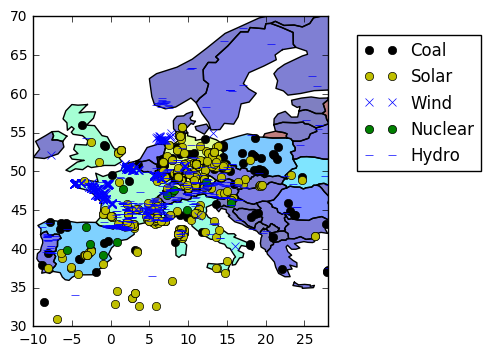

In [24]:
import geopandas as gpd
%pylab inline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = world[world['continent'] == "Europe"]
countries.plot(column='pop_est')
xlim(-10,28)
ylim(30,70)

Coal=counter.findTag("generator:source","coal")
plot(Coal.x,Coal.y,"ok",label="Coal")
Solar=counter.findTag("generator:source","solar")
plot(Solar.x,Solar.y,"oy",label="Solar")
Wind=counter.findTag("generator:source","wind")
plot(Wind.x,Wind.y,"xb",label="Wind")
Nuclear=counter.findTag("generator:source","nuclear")
plot(Nuclear.x,Nuclear.y,"og",label="Nuclear")
Hydro=counter.findTag("generator:source","hydro")
plot(Hydro.x,Hydro.y,"_b",label="Hydro")
legend(loc=(1.1,0.5))


In [4]:
Coal

,id,tags,refs,x,y
0,23681460,{u'website': u'http://www.kraftwerk-mehrum.de'...,"([330099423, 1073288758, 323206232, 582811235,...",10.093734,52.311207
0,24267119,{u'note': u'Nach Angaben der BNetzA sind die B...,"([262731146, 262731147, 2371633105, 262731148,...",6.576813,51.061901
0,24694956,"{u'name:en': u'""Orot Rabin"" Power Stations Sit...","([268426889, 1126575112, 1126575121, 268426890...",34.886701,32.476247
0,24840439,"{u'note:de': u'Umriss Kraftwerk Niederaußem', ...","([269894035, 306217309, 379503267, 379503263, ...",6.664164,50.996170
0,25649285,{u'int_name': u'Evonik Steag Gmbh Powerplant H...,"([279452207, 279598911, 279598912, 279598923, ...",7.180699,51.549907
0,25898809,"{u'plant:output:hot_water': u'1561 MW', u'powe...","([282511371, 3179699461, 3179699356, 317969935...",20.985866,52.294784
0,26389159,"{u'name': u'Kraftwerk Rostock', u'power': u'pl...","([289103944, 1135999446, 331439219, 331439218,...",12.132357,54.145530
0,26724246,"{u'name': u'Kraftwerk Stuttgart-Münster', u'po...","([293118393, 1579855436, 1579855460, 157985547...",9.217050,48.812722
0,27315902,"{u'end_date': u'2015-04-24', u'barrier': u'fen...","([299834023, 4446891374, 4446891372, 444689137...",2.414028,48.792981
0,28051874,"{u'name': u'Kraftwerk Bexbach', u'power': u'pl...","([308028464, 2473451134, 2473451133, 247331855...",7.235556,49.361522


In [5]:
Wind

,id,tags,refs,x,y
0,122280054,"{u'building': u'yes', u'power': u'generator', ...","([1366870939, 1366870941, 1366870946, 13668709...",-0.751803,45.998059
0,123732191,"{u'building': u'yes', u'manfacturer:type': u'E...","([1378821822, 1378821826, 1378821829, 13788218...",-1.333989,47.879439
0,123732199,"{u'building': u'yes', u'manfacturer:type': u'E...","([1378821932, 1378821938, 1378821941, 13788219...",-1.338533,47.880190
0,123732203,"{u'building': u'yes', u'manfacturer:type': u'E...","([1378821794, 1378821797, 1378821801, 13788218...",-1.328385,47.878515
0,133547552,"{u'building': u'yes', u'power': u'generator', ...","([1469918523, 1469918525, 1469918535, 14699185...",6.526147,49.152312
0,133547558,"{u'building': u'yes', u'power': u'generator', ...","([1469918509, 1469918513, 1469918519, 14699185...",6.522881,49.146967
0,133547562,"{u'building': u'yes', u'power': u'generator', ...","([1469918487, 1469918490, 1469918491, 14699184...",6.528574,49.144487
0,133547574,"{u'building': u'yes', u'power': u'generator', ...","([1469918464, 1469918474, 1469918476, 14699184...",6.523002,49.144150
0,133547576,"{u'building': u'yes', u'power': u'generator', ...","([1469918431, 1469918433, 1469918434, 14699184...",6.513476,49.140261
0,134525063,"{u'building': u'yes', u'source': u'cadastre-dg...","([1478995894, 1478995892, 1478995890, 14789958...",-1.760536,47.777931


In [6]:
Solar

,id,tags,refs,x,y
0,32604695,{u'note': u'http://wiki.openstreetmap.org/wiki...,"([366648967, 989328904, 2079236563, 2079236566...",8.129726,49.830974
0,118266590,{u'note': u'Weidenutzung (Schafe); Zaun ist li...,"([1330419985, 2392794789, 2392794791, 13304199...",10.847596,49.315493
0,118266591,"{u'note': u'Zaun ist linienförmig, Solarfeld f...","([1330419992, 1330419983, 2392794785, 23927947...",10.854074,49.315204
0,118586929,"{u'generator:method': u'photovoltaic', u'gener...","([1333504106, 1333504105, 1333504113, 13335041...",4.793217,44.677814
0,133129699,{u'name': u'Centrale Solaire de la Narbonnaise...,"([1464810918, 1464810903, 1464810893, 14648108...",2.977904,43.204985
0,136014567,"{u'name': u'Centrale Solaire Pathé', u'power':...","([1492655587, 1492655553, 1492655551, 14926555...",5.361395,43.412304
0,136309749,"{u'generator:method': u'photovoltaic', u'gener...","([1140895843, 1495452529, 1495452531, 14954525...",8.607728,44.942039
0,137817231,"{u'generator:method': u'photovoltaic', u'gener...","([1511358733, 1876040966, 4032296396, 18760409...",-3.421953,48.721572
0,138922063,"{u'operator': u'CNR', u'generator:method': u'p...","([1523000321, 1523000319, 1523000301, 15230003...",4.640574,43.829718
0,139808932,"{u'generator:method': u'photovoltaic', u'gener...","([1532071247, 1532071162, 1532070990, 15320711...",1.690508,43.104321
